# Part I - Bootstrapping Swap Curves

(1) In the IR Data.xlsm spreadsheeet, OIS data is provided. `Bootstrap the OIS discount factor` $D_0$(0, T) and plot the discount curve for T ∈ [0, 30].

In [1]:
import pandas as pd

from scipy.optimize import brentq
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from scipy import interpolate #wrote my own function to interpolate

#### For OIS

Day Count Convention = 30/360  
O/N Leg Freq = Daily  
Fixed Leg Freq = Annual  


In [2]:
ois_data = pd.read_csv('Data/OIS.csv')
ois_data

,Tenor,Product,Rate
0,6m,OIS,0.250%
1,1y,OIS,0.300%
2,2y,OIS,0.325%
3,3y,OIS,0.335%
4,4y,OIS,0.350%
5,5y,OIS,0.360%
6,7y,OIS,0.400%
7,10y,OIS,0.450%
8,15y,OIS,0.500%
9,20y,OIS,0.525%


In [3]:
# Data Cleaning
ois_data["OIS_rate"] = [float(i.strip('%')) for i in ois_data.Rate]
ois_data.OIS_rate = ois_data.OIS_rate/100

ois_data["Tenor"] = [0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30] # only a few so I hardcoded it

In [4]:
ois_data.head(3)

,Tenor,Product,Rate,OIS_rate
0,0.5,OIS,0.250%,0.00250
1,1.0,OIS,0.300%,0.00300
2,2.0,OIS,0.325%,0.00325


##### General Idea: In order to plot discount curve, we need to do bootstrapping, and in order to do that, we need to first calculate all the daily compounded overnight rates $f_i$ throughout the period T.

$D_o(0,6m) = \frac {1}{(1 + \frac {f_0}{360})^{180}}$  
$D_o(0,1y) = D_0(0,6m) \times D_0(6m,1y) = D_o(0,6m) \times \frac {1}{(1 + \frac {f_1}{360})^{180}}$


Let $f_0$ denote the daily compounded overnight rate for [0, 6m]. Using the 6m OIS, we have:

$PV_{fix}^{6m OIS} = PV_{flt}^{6m OIS}$

$D_o(0,6m) × 0.5 × 0.25\% = D_o(0,6m) × 0.5 × [(1 + \frac{f_0}{360})^{180} - 1]$ 

We can now solve for $f_0$.

In [5]:
f_0 = (((ois_data.OIS_rate[0]+1)**(1/180)) - 1) * 360 
f_0

0.004993795032932624

In [6]:
# crossed checked with root search method to find f_0 and the results are very similar
test_rs = lambda y: ((1/(1+y/360))**180 * 0.5 * ois_data.OIS_rate[0]) - ((1/(1+y/360))**180 * ((1 + y/360)**180 - 1))
rs = brentq(test_rs, 0, 1)
rs

0.0024984474705118964

In [7]:
x0 = (1 + (f_0/360))**180 # for ease of troubleshooting
D_6m = 1 / x0
D_6m

0.9975062344139736

Having obtained this, we can then let $f_1$ denote the daily compounded overnight rate for [6m, 1y].
Using the 1y OIS, we have:

$PV_{fix}^{1y OIS} = PV_{flt}^{1y OIS}$

$D_o(0,1y) × 0.3\% = D_o(0,1y) × [(1 + \frac{f_0}{360})^{180}(1 + \frac{f_1}{360})^{180} -1 ]$

We can now solve for $f_1$.

In [8]:
f_1 = (((1+ois_data.OIS_rate[1])/x0)**(1/180) - 1) * 360
f_1

0.0009972589437445833

In [9]:
D_1y = D_6m * 1/(1+f_1/360)**180
D_1y

0.9970089730807465

Next, we move on to the 2y OIS. Let $f_2$ denote the daily compounded overnight rate for [1y, 2y], we have

$PV_{fix}^{2y OIS} = PV_{flt}^{2y OIS}$

$[D_o(0,1y) + D_o(0,2y)] × 0.325\% = D_o(0,1y) × [(1 + \frac{f_0}{360})^{180}(1 + \frac{f_1}{360})^{180} -1 ] + D_o(0,2y) × [(1 + \frac{f_2}{360})^{360} - 1]$

- Use root search method to solve for $f$ first then substitute it back to find $D_o$

$D_o(0,2y) = D_o(0,6m) \times D_o(6m,1y) \times D_o(1y,2y) = \frac {1}{(1 + \frac {f_0}{360})^{180}} \times \frac {1}{(1 + \frac {f_1}{360})^{180}} \times \frac {1}{(1 + \frac {f_2}{360})^{360}}$ 

=> $D_o(0,2y) = D_o(0,1y) \times D_o(1y,2y) = D_o(0,1y) \times \frac {1}{(1 + \frac {f_2}{360})^{360}}$

=> $D_o(0,3y) = D_o(0,1y) \times D_o(1y,2y) \times D_o(2y,3y) = D_o(0,2y) \times D_o(2y,3y) = D_o(0,2y) \times \frac {1}{(1 + \frac {f_3}{360})^{360}}$ 

Hence, generally the below equation is used to root search the overnight rate $f_t$. 

$[\sum_{t=1}^{T-n}D_o(0,t) + D_o(0,T)] × S_{T} = D_o(0,1y)[(1 + \frac{f_0}{360})^{180}(1 + \frac{f_1}{360})^{180} -1 ] + \sum_{t=1}^{T-n}D_o(0,t)[(1 + \frac{f_t}{360})^{360} - 1] + D_o(0,T)[(1 + \frac{f_T}{360})^{360} - 1]$  

where $D_o(0,T) = D_o(0,T-n) \times D_o(T-n,T) = D_o(0,T-n) \times \frac {1}{(1 + \frac {f_T}{360})^{360*n}}$

In [10]:
# Include full time range as OIS is annual frequency

tmp_df = pd.DataFrame(data=np.arange(1,30.5,1), columns=['Tenor'])
data = []
data.insert(0,{'Tenor':0.5})
tmp_df = pd.concat([pd.DataFrame(data), tmp_df], ignore_index=True)
ois_df = pd.merge(tmp_df, ois_data, on="Tenor", how="left").drop('Product', axis =1 )

# Prepare columns
ois_df['OIS_DF'] = np.nan
ois_df['f'] = np.nan

ois_df['f'][0] = f_0
ois_df['f'][1] = f_1
ois_df['OIS_DF'][0] = D_6m
ois_df['OIS_DF'][1] = D_1y

/tmp/ipykernel_35757/166981969.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ois_df['f'][0] = f_0
/tmp/ipykernel_35757/166981969.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ois_df['f'][1] = f_1
/tmp/ipykernel_35757/166981969.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ois_df['OIS_DF'][0] = D_6m
/tmp/ipykernel_35757/166981969.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [11]:
ois_df.head(3)

,Tenor,Rate,OIS_rate,OIS_DF,f
0,0.5,0.250%,0.00250,0.997506,0.004994
1,1.0,0.300%,0.00300,0.997009,0.000997
2,2.0,0.325%,0.00325,NaN,NaN


In [12]:
# Define root search func:  pv_fix - pv_float = 0
#we set last tenor OIS_Discount(0,Ti) as x ,and do root search to solve the equation
def get_OIS_func(x): 
    float_unknown_sum = ois_df['OIS_DF'][i-1] - x 
    fix_discount_unknown_sum = 0
    diff = ois_df['OIS_DF'][i-1] - x

    for n in range(0,h-i+1):
        D = x + ((h-i+1-n-1)/(h-i+1))*diff # interpolate LIBOR df
        fix_discount_unknown_sum += D
    fix_unknown_sum = fix_discount_unknown_sum * ois_df.OIS_rate[h]


    return fix_unknown_sum + fix_known_sum - float_unknown_sum - float_known_sum 

In [13]:
i = 2
while i <=30:
    h = i

    while np.isnan(ois_df.OIS_rate[h]):
        h += 1
    k =1
    fix_known_sum = 0

    while k < i:
        fix_known = ois_df['OIS_DF'][k]*ois_df.OIS_rate[h]
        fix_known_sum += fix_known
        k+=1
    float_known_sum = ois_df.OIS_rate[i-1]*ois_df['OIS_DF'][1:i].sum()

    func = lambda x:(get_OIS_func(x))
    D_last = brentq(func, 1e-6, 1) 

    for n in range(0,h-i+1):
        ois_df['OIS_DF'][i+n] = D_last + ((h-i+1-n-1)/(h-i+1))*(ois_df['OIS_DF'][i-1] - D_last)
        ois_df['f'][i+n] = 360*((ois_df['OIS_DF'][i+n-1]/ois_df['OIS_DF'][i+n])**(1/360)-1)
    i = h+1

/tmp/ipykernel_35757/1755235192.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ois_df['OIS_DF'][i+n] = D_last + ((h-i+1-n-1)/(h-i+1))*(ois_df['OIS_DF'][i-1] - D_last)
/tmp/ipykernel_35757/1755235192.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ois_df['f'][i+n] = 360*((ois_df['OIS_DF'][i+n-1]/ois_df['OIS_DF'][i+n])**(1/360)-1)


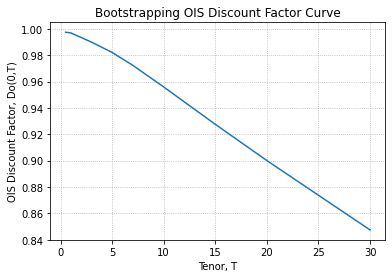

In [14]:
plt.plot(figsize=(24,16))
plt.plot(ois_df.Tenor, ois_df["OIS_DF"])
plt.xlabel("Tenor, T")
plt.ylabel("OIS Discount Factor, Do(0,T)")
plt.title("Bootstrapping OIS Discount Factor Curve")
plt.grid(linestyle='dotted')

In [15]:
def interpolate(L, R, Target):

    x_L = (Target - R)/(L-R)
    x_R = 1 - x_L

    return abs(x_L), abs(x_R) 

(2) Using the IRS data provided, `bootstrap the LIBOR discount factor` D(0,T), and plot it for T ∈ [0,30].

* Assume that the `swap market is collateralized` in cash and overnight interest is paid on collateral posted.
* Therefore, we need to discount with OIS Discount Factors found in Part 1

#### For IRS
Day Count Convention = 30/360  
Fixed Leg Freq = Semi-annual  
Floating Leg Freq = Semi Annual  

In [16]:
irs_data = pd.read_csv('Data/IRS.csv')
irs_data.head(3)

,Tenor,Product,Rate
0,6m,LIBOR,2.50%
1,1y,IRS,2.80%
2,2y,IRS,3.00%


In [17]:
# Data Cleaning and Preparation
irs_data["IRS_rate"] = [float(i.strip('%')) for i in irs_data.Rate]
irs_data.IRS_rate = irs_data.IRS_rate/100

irs_data["Tenor"] = [0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30] # only a few so I hardcoded it

accrusal_frac = 0.5

In [18]:
irs_data.head(3)

,Tenor,Product,Rate,IRS_rate
0,0.5,LIBOR,2.50%,0.025
1,1.0,IRS,2.80%,0.028
2,2.0,IRS,3.00%,0.030


#### Interpolating all the semi-annual OIS Discount Factors

In [19]:
ois_df.head(3)

,Tenor,Rate,OIS_rate,OIS_DF,f
0,0.5,0.250%,0.00250,0.997506,0.004994
1,1.0,0.300%,0.00300,0.997009,0.000997
2,2.0,0.325%,0.00325,0.993531,0.003495


In [20]:
semi_ois_df = [ois_df.OIS_DF[0], ois_df.OIS_DF[1]]

# Interpolating all the semi-annual OIS Discount Factors
for t in range(1,len(ois_df)):
    if (ois_df.Tenor[t] - ois_df.Tenor[t-1]) > 0.5:
        for x in np.arange(ois_df.Tenor[t-1] + 0.5, ois_df.Tenor[t]+0.5, 0.5):
            # print(x)
            left_weight, right_weight = interpolate(ois_df.Tenor[t-1], ois_df.Tenor[t], x)
            # print(left_weight, right_weight)

            tmp = left_weight*ois_df.OIS_DF[t-1] + right_weight*ois_df.OIS_DF[t]
            semi_ois_df.append(tmp)

len(semi_ois_df)
# semi_ois_df

60

##### Background Equations (Concept)

$PV_{fix} = K \sum _{i=1}^n\triangle_{i-1} D(0,T_i)$

$PV_{flt} = D(0, T_0) - D(0,T_n)$

$PV_{fix} = PV_{flt}$  
$=> K \sum _{i=1}^n\triangle_{i-1} D(0,T_i) = D(0, T_0) - D(0,T_n)$


* Swap market is collateralized

Given the 6 months LIBOR rate $L_{6m}$ = 2.5%,   
D(0, 6m) = $\frac {1}{1+\triangle_{6m}L_{6m}} = \frac {1}{1+(0.5)(2.5\%)}$ 

In [21]:
d1 = 1/(1+accrusal_frac*irs_data.IRS_rate[0])
print("D(0,6m) = ", d1)

D(0,6m) =  0.9876543209876544


##### Bootstrapping D(0,1y)

$PV_{fix} = PV_{flt}$  
$D_o(0,6m) \times \triangle \times 2.8\% + D_o(0,1y) \times \triangle \times 2.8\% = D_o(0,6m) \times \triangle L_{6m} + D_o(0,1y) \times \triangle L(6m,1y)$  

$\implies \triangle S_{1y}[D_o(0,6m) + D_o(0,1y)] = \triangle [D_o(0,6m)L_{6m} + D_o(0,1y)L(6m,1y)]$

$\implies L(6m,1y) = \frac {S_{1y} [D_o(0,6m) + D_o(0,1y)] - D_o(0,6m)L_{6m}}{D_o(0,1y)}$ 

In [22]:
l1 = (irs_data.IRS_rate[1]*(ois_df.OIS_DF[0] + ois_df.OIS_DF[1]) - ois_df.OIS_DF[0]*irs_data.IRS_rate[0]) / ois_df.OIS_DF[1]
l1

0.031001496259351672

Knowing that forward LIBOR rate is given as  

$L(6m,1y) = \frac{1}{\triangle} \frac{D(0,6m) - D(0,1y)}{D(0,1y)}$  

$\implies D(0,1y) = \frac{D(0,6m)}{1 + \triangle L(6m,1y)}$

In [23]:
d2 = d1/(1 + accrusal_frac*l1)
print("D(0,1y) = ", d2)

D(0,1y) =  0.9725786246900278


##### Bootstrapping D(0,2y):
$PV_{fix} = PV_{flt}$  

$\triangle 3\% [D_o(0,6m) + D_o(0,1y) + D_o(0,1.5y) + D_o(0,2y)] = $
$\triangle [D_o(0,6m)L(0,6m) + D_o(0,1y)L(6m,1y) + D_o(0,1.5y)L(1y,1.5y) + D_o(0,2y)L(1.5y,2y)]$


- $L(1y,1.5y) = \frac{1}{\triangle} \frac {D(0,1y) - D(0,1.5y)}{D(0,1.5y)}$
- $D(0,1.5y) = \frac{D(0,1y)+ D(0,2y)}{2}$

$=> L(1y,1.5y) = \frac{1}{\triangle} \frac {D(0,1y) - [0.5D(0,1y)+ 0.5D(0,2y)]}{0.5D(0,1y)+ 0.5D(0,2y)} = \frac{1}{\triangle} \frac {0.5D(0,1y) - 0.5D(0,2y)]}{0.5D(0,1y)+ 0.5D(0,2y)} = \frac{1}{\triangle} \frac {D(0,1y) - D(0,2y)]}{D(0,1y)+ D(0,2y)}$  

- $L(1.5y,2y) = \frac{1}{\triangle} \frac {D(0,1.5y) - D(0,2y)}{D(0,2y)}$
- $D(0,1.5y) = \frac{D(0,1y)+ D(0,2y)}{2}$

$=> L(1.5y,2y) = \frac{1}{\triangle} \frac {[0.5D(0,1y) + 0.5D(0,2y)] - D(0,2y)}{D(0,2y)} = \frac{1}{\triangle} \frac {0.5[D(0,1y) - D(0,2y)]}{D(0,2y)}$

In [24]:
def calculateInterpolatedDF(lw, rw, lhs, rhs, target_DF):

    c = 1/accrusal_frac
    tmp_semi_ois_df = semi_ois_df[2*lhs-1:2*rhs]
    sum_RHS = 0 

    for l in range(1, len(lw)):
        lhs_intp_df = (lw[l-1]*libor_df[2*lhs-1] + rw[l-1]*target_DF)
        rhs_intp_df = (lw[l]*libor_df[2*lhs-1] + rw[l]*target_DF)

        sum_RHS += tmp_semi_ois_df[l-1]*c*((lhs_intp_df - rhs_intp_df)/rhs_intp_df)

    return sum_RHS 

In [25]:
libor_df = [d1, d2]
forward_libor = [irs_data.IRS_rate[0], l1]
# print(libor_df); print(forward_libor)

flt_sum = semi_ois_df[0]*forward_libor[0] + semi_ois_df[1]*forward_libor[1]

for t in range(2,11):
    # print(t)
    idx = int(irs_data["Tenor"][t])
    pv_fix = irs_data.IRS_rate[t]*sum(semi_ois_df[:2*idx])

    lw = []
    rw = []

    # For loop just to calculate weights in each interval
    for x in np.arange(irs_data["Tenor"][t-1], irs_data["Tenor"][t]+0.5, 0.5):
        # print(x)
        LHS, RHS = int(irs_data["Tenor"][t-1]), int(irs_data["Tenor"][t])
        left_weight, right_weight = interpolate(LHS, RHS, x)
        # print(left_weight, right_weight)
        lw.append(left_weight)
        rw.append(right_weight)

    tmp_df = brentq(lambda x: pv_fix - (flt_sum + calculateInterpolatedDF(lw, rw, LHS, RHS, x)), 1e-6, 1)
    # print(tmp_df)

    for l in range(1, len(lw)):
        libor_df.append((lw[l]*libor_df[2*LHS-1] + rw[l]*tmp_df))

    # print(libor_df)

    flt_sum +=  calculateInterpolatedDF(lw, rw, LHS, RHS, libor_df[-1])

In [26]:
len(libor_df), forward_libor

(60, [0.025, 0.031001496259351672])

In [27]:
irs_df = pd.DataFrame()
irs_df["Tenor"] = np.arange(0.5, 30.5, 0.5)
irs_df["LIBOR_DF"] = libor_df

irs_df = pd.merge(irs_df, irs_data, on="Tenor", how="left").drop(["Product", "Rate"], axis=1)

irs_df.head(3)

,Tenor,LIBOR_DF,IRS_rate
0,0.5,0.987654,0.025
1,1.0,0.972579,0.028
2,1.5,0.957406,NaN


In [28]:
irs_df.head(3)

,Tenor,LIBOR_DF,IRS_rate
0,0.5,0.987654,0.025
1,1.0,0.972579,0.028
2,1.5,0.957406,NaN


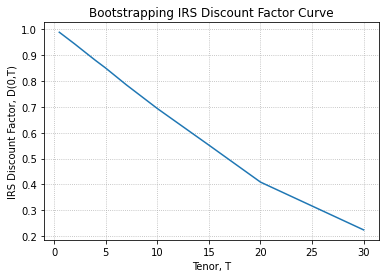

In [29]:
plt.plot(figsize=(24,16))
plt.plot(irs_df["Tenor"], irs_df["LIBOR_DF"])
plt.xlabel("Tenor, T")
plt.ylabel("IRS Discount Factor, D(0,T)")
plt.title("Bootstrapping IRS Discount Factor Curve")
plt.grid(linestyle='dotted')

(3) Calculate the following forward swap rates: 

- 1y×1y, 1y×2y, 1y×3y, 1y×5y, 1y×10y
- 5y×1y, 5y×2y, 5y×3y, 5y×5y, 5y×10y
- 10y×1y, 10y×2y, 10y×3y, 10y×5y, 10y×10y

Use linear interpolation on discount factors when necessary.

In [30]:
df_combined = pd.merge(irs_df, ois_df, on="Tenor", how="left")
df_combined.drop("Rate", axis = 1, inplace=True)
df_combined.head(3)

,Tenor,LIBOR_DF,IRS_rate,OIS_rate,OIS_DF,f
0,0.5,0.987654,0.025,0.0025,0.997506,0.004994
1,1.0,0.972579,0.028,0.0030,0.997009,0.000997
2,1.5,0.957406,NaN,NaN,NaN,NaN


In [31]:
df_combined["OIS_DF"] = df_combined["OIS_DF"].interpolate()
# df_combined["Forward LIBOR"] = df_combined["Forward LIBOR"].interpolate()

df_combined.head(3)

,Tenor,LIBOR_DF,IRS_rate,OIS_rate,OIS_DF,f
0,0.5,0.987654,0.025,0.0025,0.997506,0.004994
1,1.0,0.972579,0.028,0.0030,0.997009,0.000997
2,1.5,0.957406,NaN,NaN,0.995270,NaN


In [32]:
df_combined['Foward_LIBOR'] = np.NAN
df_combined['Foward_LIBOR'][0] = irs_data.IRS_rate[0]
df_combined['Foward_LIBOR'][1] =l1

df_combined.head()

,Tenor,LIBOR_DF,IRS_rate,OIS_rate,OIS_DF,f,Foward_LIBOR
0,0.5,0.987654,0.025,0.00250,0.997506,0.004994,0.025000
1,1.0,0.972579,0.028,0.00300,0.997009,0.000997,0.031001
2,1.5,0.957406,NaN,NaN,0.995270,NaN,NaN
3,2.0,0.942234,0.030,0.00325,0.993531,0.003495,NaN
4,2.5,0.926412,NaN,NaN,0.991773,NaN,NaN


In [33]:
# while loop to solve forward LIBOR for each tenor
i = 3
while i <= 60:
    h = i

    for n in range(0,h-i+2): # Populate Forward LIBOR
        df_combined['Foward_LIBOR'][i-1+n] = (df_combined['LIBOR_DF'][i-2+n]-df_combined['LIBOR_DF'][i-1+n]) /\
        (0.5*df_combined['LIBOR_DF'][i-1+n])

    i = h+2 # increase by 1 year (0.5*2)

In [34]:
df_combined.rename(columns= {"Tenor": "Tenor (year)", 
                            "LIBOR_DF": "LIBOR Discount Factor", 
                            "IRS_rate": "IRS Rate", 
                            "OIS_rate": "OIS Rate", 
                            "OIS_DF": "OIS Discount Factor",
                            "f": "OIS Overnight Rate",
                            "Foward_LIBOR": "Forward LIBOR"}, 
                    inplace=True)

In [35]:
def par_swap_rate_solver(start,duration):
    end = start + duration
    start_i = start*2 #find the start index
    end_i = end*2-1 #find the end index
    float_leg_sum = 0 # initialize
    fix_discount_sum = 0 # initialize
    while start_i <= end_i:
        float_leg = df_combined['Forward LIBOR'][start_i]*0.5*df_combined['OIS Discount Factor'][start_i] # float leg value at each tenor
        float_leg_sum += float_leg  
        fix_discount = 0.5*df_combined['OIS Discount Factor'][start_i] #fix discount at each tenor * 0.5
        fix_discount_sum += fix_discount
        start_i += 1
    par_swap_rate = float_leg_sum/fix_discount_sum # formula in the markdown
    return par_swap_rate

In [36]:
df_combined.head(3)

,Tenor (year),LIBOR Discount Factor,IRS Rate,OIS Rate,OIS Discount Factor,OIS Overnight Rate,Forward LIBOR
0,0.5,0.987654,0.025,0.0025,0.997506,0.004994,0.025000
1,1.0,0.972579,0.028,0.0030,0.997009,0.000997,0.031001
2,1.5,0.957406,NaN,NaN,0.995270,NaN,0.031695


In [37]:
df_combined.to_csv('df_comb.csv',sep=',')


In [38]:
# print(df_combined)

In [39]:
df_FowardSwap = pd.DataFrame([['1Y','1Y',par_swap_rate_solver(1,1)],['1Y','2Y',par_swap_rate_solver(1,2)],['1Y','3Y',par_swap_rate_solver(1,3)],['1Y','5Y',par_swap_rate_solver(1,5)],['1Y','10Y',par_swap_rate_solver(1,10)],\
                             ['5Y','1Y',par_swap_rate_solver(5,1)],['5Y','2Y',par_swap_rate_solver(5,2)],['5Y','3Y',par_swap_rate_solver(5,3)],['5Y','5Y',par_swap_rate_solver(5,5)],['5Y','10Y',par_swap_rate_solver(5,10)],\
                            ['10Y','1Y',par_swap_rate_solver(10,1)],['10Y','2Y',par_swap_rate_solver(10,2)],['10Y','3Y',par_swap_rate_solver(10,3)],['10Y','5Y',par_swap_rate_solver(10,5)],['10Y','10Y',par_swap_rate_solver(10,10)]],\
                            columns=['Expiry','Tenor','Swap_Rate'])

In [40]:
df_FowardSwap.head()

,Expiry,Tenor,Swap_Rate
0,1Y,1Y,0.031950
1,1Y,2Y,0.033200
2,1Y,3Y,0.033947
3,1Y,5Y,0.035184
4,1Y,10Y,0.038335


In [41]:
df_FowardSwap["color"] = [1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10]

In [42]:
df_FowardSwap['Expiry'] = df_FowardSwap['Expiry'].astype(str)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


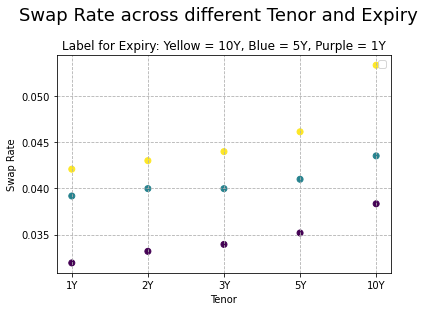

In [43]:
plt.plot(figsize=(24,16))
plt.scatter(df_FowardSwap.Tenor, df_FowardSwap.Swap_Rate, c=df_FowardSwap.color)
plt.xlabel("Tenor")
plt.ylabel("Swap Rate")
plt.suptitle("Swap Rate across different Tenor and Expiry", y=1.05, fontsize=18)
plt.title("Label for Expiry: Yellow = 10Y, Blue = 5Y, Purple = 1Y")

plt.grid(linestyle='--')
plt.legend()
plt.show()

In [44]:
df_FowardSwap.to_csv('df_ForwardSwap.csv',sep=',')